In [1]:
%tensorflow_version 1.x # Select module of the tensorflow
!ls -l #list the number of files 

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # Select module of the tensorflow`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
total 4
drwxr-xr-x 1 root root 4096 Jun 15 13:37 sample_data


In [2]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-06-29 08:04:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.34.225, 34.196.173.159, 54.196.69.145, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.34.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  19.2MB/s    in 0.7s    

2021-06-29 08:04:33 (19.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [3]:
#the logs that are created while training 
LOG_DIR = "/root/models/trained"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
#The link to tensorboard.
#works after the training starts.
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [4]:
!python -c 'import matplotlib as tf; print(tf.__version__)' # Check the version of the tensorflow


3.2.2


In [6]:
%cd
!git clone https://github.com/tensorflow/models.git # Import required files from the website


/root
Cloning into 'models'...
remote: Enumerating objects: 58054, done.
remote: Counting objects: 100% (471/471), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 58054 (delta 298), reused 429 (delta 275), pack-reused 57583
Receiving objects: 100% (58054/58054), 573.17 MiB | 31.50 MiB/s, done.
Resolving deltas: 100% (40246/40246), done.


In [7]:
!pwd # Check for the current destination route

/root


In [9]:
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'
!pip install tf_slim
!python object_detection/builders/model_builder_test.py
#!python3 --version
!python -c 'import tensorflow as tf; print(tf.__version__)'

     |████████████████████████████████| 358kB 3.9MB/s 
1.15.2


In [11]:
%cd /root/models/
!git clone https://github.com/paradoxials/seerDataset #Import the dataset

/root/models
Cloning into 'seerDataset'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 42 (delta 14), reused 42 (delta 14), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [12]:
os.getcwd()

'/root/models'

In [14]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
	'''
    for directory in ['train','testing']:
        image_path = os.path.join(os.getcwd(), 'images/{}'.format(directory).format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('data/{}_labels.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')
	''' 
	image_path = os.path.join(os.getcwd(), 'seerDataset/images/train')
	xml_df = xml_to_csv(image_path)
	xml_df.to_csv('seerDataset/data/train_labels.csv', index=None)

	image_path = os.path.join(os.getcwd(), 'seerDataset/images/test')
	xml_df = xml_to_csv(image_path)
	xml_df.to_csv('seerDataset/data/test_labels.csv',index=None)

main()

In [16]:
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
#!export PYTHONPATH=$PYTHONPATH: /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/:/usr/local/lib/python3.6/dist-packages/tensorflow/models/research/slim
#!pwd
#!python /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/object_detection/builders/model_builder_test.py
#!python setup.py build
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=train.record

  # Create test data:
  python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=test.record
"""
#IMPORTANT!! guys change the generate_tfrecord.py...more like open generate_tfrecord.py then try to add more of your classes that you haved labeled... e.g the class for stairs,watter puddles, trees, vehicles and stuff
%cd /root/models/seerDataset/tfrecord
!python generate_tfrecord.py --csv_input=/root/models/seerDataset/data/train_labels.csv  --output_path=train.record --image_dir=/root/models/seerDataset/images/train
!python generate_tfrecord.py --csv_input=/root/models/seerDataset/data/test_labels.csv  --output_path=test.record --image_dir=/root/models/seerDataset/images/test





/root/models/research
/root/models/seerDataset/tfrecord


W0629 08:23:37.575663 139814492407680 module_wrapper.py:139] From generate_tfrecord.py:94: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0629 08:23:37.591087 139814492407680 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Traceback (most recent call last):
  File "generate_tfrecord.py", line 108, in <module>
    tf.app.run()
  File "/tensorflow-1.15.2/python3.7/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "generate_tfrecord.py", line 99, in main
    tf_example = create_tf_example(group, path)
  File

In [17]:
%cd ~/models

import os
import shutil
import glob
import urllib
import tarfile
from requests import get

MODEL = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  with open(MODEL_FILE, "wb") as file:
    # get request
    response = get(DOWNLOAD_BASE + MODEL_FILE)
    # write to file
    file.write(response.content)
    #opener = urllib.URLopener()
    #opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/root/models


In [18]:
# Move Config file to directory "models"
shutil.move("/root/models/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config", "/root/models") 

'/root/models/ssd_mobilenet_v1_coco.config'

In [19]:
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
#!export PYTHONPATH=$PYTHONPATH: /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/:/usr/local/lib/python3.6/dist-packages/tensorflow/models/research/slim
#!pwd
#!python /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/object_detection/builders/model_builder_test.py
#!python setup.py build
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

# Edit Pipeline 
import tensorflow as tf
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

pipeline = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          
config_path = '/root/models/ssd_mobilenet_v1_coco.config'
with tf.gfile.GFile( config_path, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline)

pipeline.train_input_reader.tf_record_input_reader.input_path[:] = ['/root/models/seerDataset/tfrecord/train.record'] 
pipeline.train_input_reader.label_map_path = '/root/models/seerDataset/data/object-detection.pbtxt'
pipeline.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['/root/models/seerDataset/tfrecord/test.record'] 
pipeline.eval_input_reader[0].label_map_path = '/root/models/seerDataset/data/object-detection.pbtxt'
pipeline.train_config.fine_tune_checkpoint = '/root/models/pretrained_model/model.ckpt'
pipeline.train_config.num_steps = 500
pipeline.model.ssd.num_classes = 5
pipeline.eval_config.num_examples = 15

config_text = text_format.MessageToString(pipeline)                                                                                                                                                                                                        
with tf.gfile.Open( config_path, "wb") as f:                                                                                                                                                                                                                       
    f.write(config_text)


/root/models/research


In [20]:
# Change into the models directory
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

# Begin training
!python /root/models/research/object_detection/legacy/train.py \
    --logtostderr \
    --train_dir=/root/models/trained \
    --pipeline_config_path=/root/models/ssd_mobilenet_v1_coco.config


/root/models/research
Instructions for updating:
Use object_detection/model_main.py.
W0629 08:34:51.415898 140091445770112 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/absl/app.py:251: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.
Instructions for updating:
Please switch to tf.train.create_global_step
W0629 08:34:51.435972 140091445770112 deprecation.py:323] From /root/models/research/object_detection/legacy/trainer.py:265: create_global_step (from tf_slim.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.create_global_step
INFO:tensorflow:Reading unweighted datasets: ['/root/models/seerDataset/tfrecord/train.record']
I0629 08:34:51.458152 140091445770112 dataset_builder.py:163] Reading unweighted datasets: ['/root/models/seerDataset/tfrecord/train.record']
INFO:tensorflow:Reading record datasets for inp

In [21]:
#Export trained model 
%cd /root/models/research
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'
!python /root/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/models/ssd_mobilenet_v1_coco.config \
    --output_directory=/root/models/fine_tuned_model \
    --trained_checkpoint_prefix=/root/models/trained/model.ckpt-500

/root/models/research
Instructions for updating:
Please use `layer.__call__` method instead.
W0629 10:39:33.790080 140550491645824 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0629 10:39:35.468146 140550491645824 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0629 10:39:35.512548 140550491645824 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0629 10:39:35.556119 140550491645824 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth o

In [22]:
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
# This is needed to display the images.
%matplotlib inline


In [23]:
# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/models/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/root/models/seerDataset/data/object-detection.pbtxt'
# Input how many labels you have
NUM_CLASSES = 5


In [24]:
print(PATH_TO_CKPT)

/root/models/fine_tuned_model/frozen_inference_graph.pb


In [25]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


In [27]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


In [28]:
# Check the categories...basta inside the object_detection.pbtext
print(category_index)


{1: {'id': 1, 'name': 'tree'}, 2: {'id': 2, 'name': 'tree branch'}, 3: {'id': 3, 'name': 'vehicle'}, 4: {'id': 4, 'name': 'pedestrian lane'}, 5: {'id': 5, 'name': 'pole'}}


In [29]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


In [30]:
# For the sake of simplicity we will use only 5 images:
# from image1.jpg
# to image5.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/models/seerDataset/images/test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


In [31]:
# Check images
print(TEST_IMAGE_PATHS)

['/root/models/seerDataset/images/test/1.jpg', '/root/models/seerDataset/images/test/2.jpg', '/root/models/seerDataset/images/test/3.jpg', '/root/models/seerDataset/images/test/4.jpg', '/root/models/seerDataset/images/test/5.jpg', '/root/models/seerDataset/images/test/6.jpg']


In [32]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


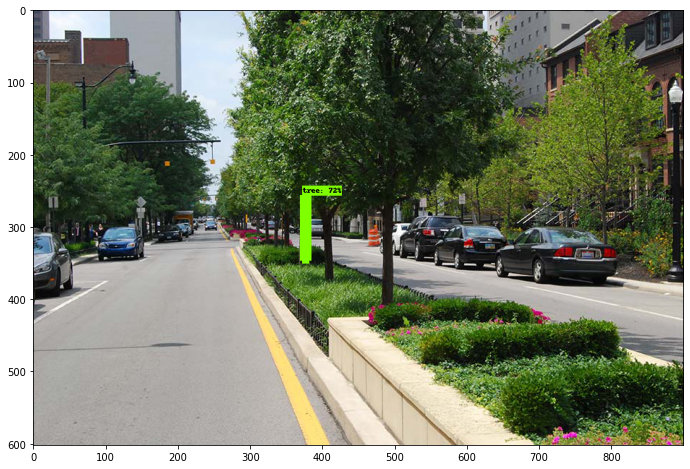

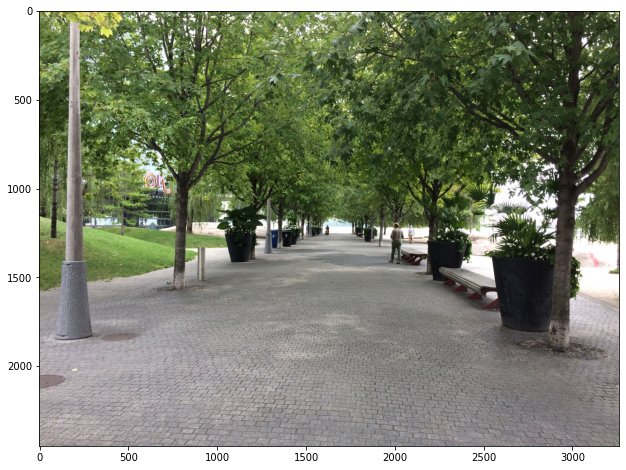

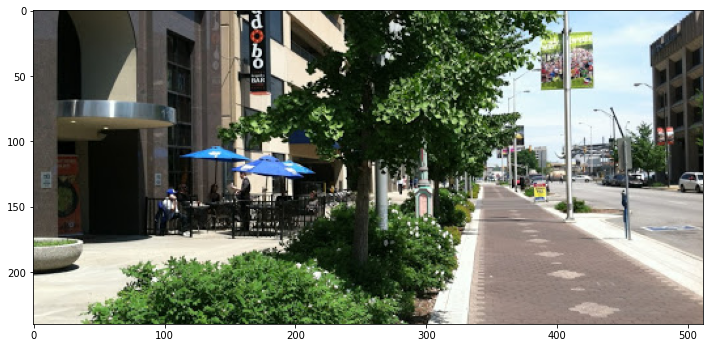

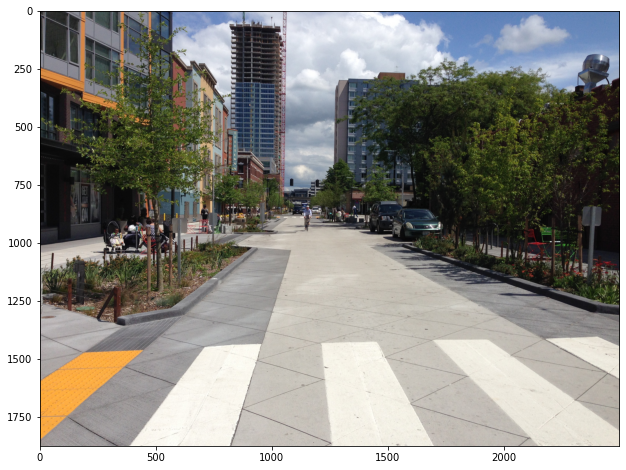

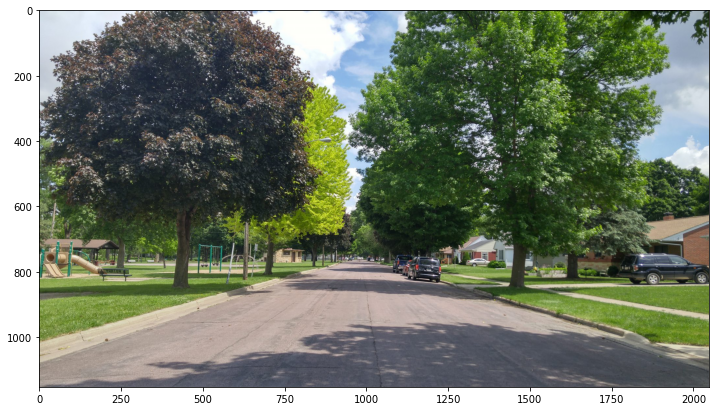

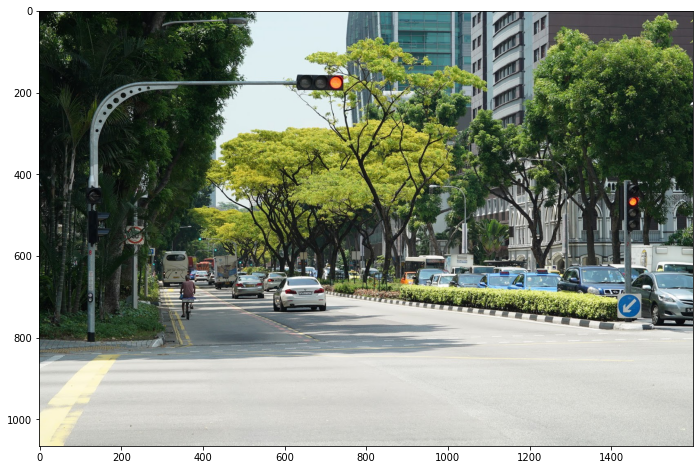

In [33]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
